In [3]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from torch import nn
import random

In [4]:
import sys
sys.path.append("..")
# from steganogan.decoders import DenseDecoderNLayers
from steganogan.decoders import BasicDecoder, DenseDecoder, DenseDecoderNLayers
from steganogan import SteganoGAN

In [109]:
import torch
import torchvision
from torch.optim import LBFGS
import torch.nn.functional as F

In [5]:
from tqdm import tqdm, trange

In [204]:
def shuffle_params(m):
    if type(m)==nn.Conv2d or type(m)==nn.BatchNorm2d:
        param = m.weight
        m.weight.data = nn.Parameter(torch.tensor(np.random.normal(0, 1, param.shape)).float())
        
        param = m.bias
        m.bias.data = nn.Parameter(torch.zeros(len(param.view(-1))).float().reshape(param.shape))
    if type(m)==nn.BatchNorm2d:
        if "track_running_stats" in m.__dict__:
            m.track_running_stats=False
#         

In [206]:
class normLayer(nn.Module):
    def __init__(self):
        super(normLayer, self).__init__()
    def forward(self, x):
        b,c,h,w = x.shape
        assert b == 1
        mean = x.view(c, -1).mean(-1)
        std = x.view(c, -1).std(-1)
        x = x - mean.reshape([1, c, 1, 1])
        x = x / (std + 1e-7).reshape([1,c,1,1])
        return x

In [205]:
class BasicDecoder(nn.Module):
    """
    The BasicDecoder module takes an steganographic image and attempts to decode
    the embedded data tensor.

    Input: (N, 3, H, W)
    Output: (N, D, H, W)
    """

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.layers = nn.Sequential(
            self._conv2d(3, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            normLayer() if self.yan_norm else nn.BatchNorm2d(self.hidden_size),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            normLayer() if self.yan_norm else nn.BatchNorm2d(self.hidden_size),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            normLayer() if self.yan_norm else nn.BatchNorm2d(self.hidden_size),

            self._conv2d(self.hidden_size, self.data_depth)
        )

        return [self.layers]

    def __init__(self, data_depth, hidden_size, yan_norm=False):
        super().__init__()
        self.version = '1'
        self.data_depth = data_depth
        self.hidden_size = hidden_size
        self.yan_norm = yan_norm

        self._models = self._build_models()

    def upgrade_legacy(self):
        """Transform legacy pretrained models to make them usable with new code versions."""
        # Transform to version 1
        if not hasattr(self, 'version'):
            self._models = [self.layers]

            self.version = '1'

    def forward(self, x):
        x = self._models[0](x)

        if len(self._models) > 1:
            x_list = [x]
            for layer in self._models[1:]:
                x = layer(torch.cat(x_list, dim=1))
                x_list.append(x)

        return x

In [218]:
num_bits = 3
yan_norm = False
# models
model_name = "steg_decode_new"
if model_name == "steg_decode":
#     steganogan = SteganoGAN.load(architecture='dense', path=None, cuda=True, verbose=True)
    steganogan = SteganoGAN.load(path="demo_1.1.steg", cuda=True, verbose=True)
    model = steganogan.decoder
    model.apply(shuffle_params)
elif model_name == "steg_decode_new":
    model = BasicDecoder(num_bits, hidden_size=128, yan_norm=yan_norm)
    model.apply(shuffle_params)
    model.to('cuda')
else:
    print("unknown model")

model.to('cuda')
if not yan_norm:
    print(model.layers[2].track_running_stats)
old_dict = model.state_dict()

False


In [17]:
model.layers[2].weight.requires_grad

True

In [18]:
# load image
image = "/home/vk352/FaceDetection/datasets/sample/obama2.jpg"
image = imread(image, pilmode='RGB') 
image.shape

(612, 450, 3)

In [210]:
# extract a bit vector
# image = "/home/vk352/FaceDetection/datasets/sample/obama2.jpg"
image = "/home/vk352/FaceDetection/datasets/data512x512/00001.jpg"
image = imread(image, pilmode='RGB') / 255.0
image = torch.FloatTensor(image).permute(2, 1, 0).unsqueeze(0)
image = image.to('cuda')
out = model(image)
# image = self.decoder(image).view(-1) > 0

In [211]:
target = torch.bernoulli(torch.empty(out.shape).uniform_(0, 1)).to(out.device)
# target = torch.empty(out.shape).random_(256).to(out.device)
target.shape

torch.Size([1, 3, 512, 512])

In [212]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
criterion1 = torch.nn.L1Loss(reduction='sum')
criterion2 = torch.nn.MSELoss(reduction='sum')

def get_loss(outputs, target, loss_mode):
    if loss_mode == "BCE":
        loss = criterion(outputs, target)
    elif loss_mode == "log":
        loss = -(target * 2 - 1) * outputs
        loss = torch.nn.functional.softplus(loss)  # log(1+exp(x))
        loss = torch.sum(loss)
    elif loss_mode == "hingelog":
        loss = -(target * 2 - 1) * outputs
        loss = torch.nn.functional.softplus(loss)  # log(1+exp(x))
        loss = torch.max(loss-hinge, torch.zeros(target.shape).to(target.device))
        loss = torch.sum(loss)
    elif loss_mode == "L1":
        outputs = F.sigmoid(outputs) * 255
        loss = criterion1(outputs, target)
    elif loss_mode == "L2":
        outputs = F.sigmoid(outputs) * 255
        loss = criterion2(outputs, target)
    return loss

In [213]:
loss_mode = "log"
hinge = 0.3

In [220]:
# lbfgs

lbfgsacc = {}
lbfgsimg = {}

steps = 1000
eps = 0.2
adv_image = image.clone().detach()
max_iter = 20

for alpha in [0.3, 0.4, 0.5]:
    adv_image = image.clone().detach()
    print("alpha:", alpha)
    accuracy = []

    for i in trange(steps // max_iter):
        adv_image.requires_grad = True
        optimizer = LBFGS([adv_image], lr=alpha, max_iter=max_iter)

        def closure():
            outputs = model(adv_image)
            loss = get_loss(outputs, target, loss_mode)

            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        delta = torch.clamp(adv_image - image, min=-eps, max=eps)
        adv_image = torch.clamp(image + delta, min=0, max=1)
        adv_image = torch.clamp(adv_image*255, 0, 255).int().float()/255.
        adv_image = adv_image.detach()
        
        if loss_mode in ["L1", "L2"]:
            acc = len(torch.nonzero(torch.abs(F.sigmoid(model(adv_image)).float().view(-1)*255-target.view(-1)) > 128)) / target.numel()
        else:
            acc = len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel()
        print("error", acc)
        accuracy.append(acc)

    lbfgsacc[alpha] = accuracy
    lbfgsimg[alpha] = adv_image.cpu().squeeze().permute(2,1,0)



















  0%|          | 0/50 [00:00<?, ?it/s]

alpha: 0.3




















  2%|▏         | 1/50 [00:01<01:17,  1.58s/it]

error 0.25926971435546875




















  4%|▍         | 2/50 [00:03<01:14,  1.56s/it]

error 0.1822942097981771




















  6%|▌         | 3/50 [00:04<01:12,  1.55s/it]

error 0.13277689615885416




















  8%|▊         | 4/50 [00:06<01:10,  1.53s/it]

error 0.09900156656901042




















 10%|█         | 5/50 [00:07<01:08,  1.53s/it]

error 0.07422637939453125




















 12%|█▏        | 6/50 [00:09<01:07,  1.53s/it]

error 0.059356689453125




















 14%|█▍        | 7/50 [00:10<01:05,  1.52s/it]

error 0.049425760904947914




















 16%|█▌        | 8/50 [00:12<01:03,  1.52s/it]

error 0.0413665771484375




















 18%|█▊        | 9/50 [00:13<01:02,  1.52s/it]

error 0.036739349365234375




















 20%|██        | 10/50 [00:15<01:00,  1.52s/it]

error 0.032207489013671875




















 22%|██▏       | 11/50 [00:16<00:59,  1.52s/it]

error 0.029827117919921875




















 24%|██▍       | 12/50 [00:18<00:57,  1.52s/it]

error 0.02704620361328125




















 26%|██▌       | 13/50 [00:19<00:56,  1.52s/it]

error 0.025905609130859375




















 28%|██▊       | 14/50 [00:21<00:54,  1.52s/it]

error 0.024393717447916668




















 30%|███       | 15/50 [00:22<00:53,  1.52s/it]

error 0.023106892903645832




















 32%|███▏      | 16/50 [00:24<00:51,  1.52s/it]

error 0.022183736165364582




















 34%|███▍      | 17/50 [00:25<00:50,  1.52s/it]

error 0.021289825439453125




















 36%|███▌      | 18/50 [00:27<00:48,  1.53s/it]

error 0.020697275797526043




















 38%|███▊      | 19/50 [00:28<00:47,  1.53s/it]

error 0.020343780517578125




















 40%|████      | 20/50 [00:30<00:45,  1.53s/it]

error 0.019701639811197918




















 42%|████▏     | 21/50 [00:32<00:44,  1.53s/it]

error 0.019571940104166668




















 44%|████▍     | 22/50 [00:33<00:42,  1.53s/it]

error 0.019101460774739582




















 46%|████▌     | 23/50 [00:35<00:41,  1.53s/it]

error 0.01882171630859375




















 48%|████▊     | 24/50 [00:36<00:39,  1.53s/it]

error 0.018393198649088543




















 50%|█████     | 25/50 [00:38<00:38,  1.53s/it]

error 0.018541971842447918




















 52%|█████▏    | 26/50 [00:39<00:36,  1.53s/it]

error 0.018157958984375




















 54%|█████▍    | 27/50 [00:41<00:35,  1.53s/it]

error 0.018198649088541668




















 56%|█████▌    | 28/50 [00:42<00:33,  1.54s/it]

error 0.018215179443359375




















 58%|█████▊    | 29/50 [00:44<00:32,  1.54s/it]

error 0.01796722412109375




















 60%|██████    | 30/50 [00:45<00:30,  1.54s/it]

error 0.018044789632161457




















 62%|██████▏   | 31/50 [00:47<00:29,  1.54s/it]

error 0.017945607503255207




















 64%|██████▍   | 32/50 [00:48<00:27,  1.54s/it]

error 0.017751057942708332




















 66%|██████▌   | 33/50 [00:50<00:26,  1.54s/it]

error 0.017965952555338543




















 68%|██████▊   | 34/50 [00:51<00:24,  1.54s/it]

error 0.017930348714192707




















 70%|███████   | 35/50 [00:53<00:23,  1.54s/it]

error 0.017896016438802082




















 72%|███████▏  | 36/50 [00:55<00:21,  1.54s/it]

error 0.018129984537760418




















 74%|███████▍  | 37/50 [00:56<00:19,  1.53s/it]

error 0.017864227294921875




















 76%|███████▌  | 38/50 [00:58<00:18,  1.54s/it]

error 0.018266042073567707




















 78%|███████▊  | 39/50 [00:59<00:16,  1.54s/it]

error 0.018441518147786457




















 80%|████████  | 40/50 [01:01<00:15,  1.54s/it]

error 0.018438975016276043




















 82%|████████▏ | 41/50 [01:02<00:13,  1.54s/it]

error 0.018474578857421875




















 84%|████████▍ | 42/50 [01:04<00:12,  1.54s/it]

error 0.018702189127604168




















 86%|████████▌ | 43/50 [01:05<00:10,  1.54s/it]

error 0.018726348876953125




















 88%|████████▊ | 44/50 [01:07<00:09,  1.54s/it]

error 0.018939971923828125




















 90%|█████████ | 45/50 [01:08<00:07,  1.54s/it]

error 0.01922607421875




















 92%|█████████▏| 46/50 [01:10<00:06,  1.54s/it]

error 0.019297281901041668




















 94%|█████████▍| 47/50 [01:11<00:04,  1.54s/it]

error 0.019718170166015625




















 96%|█████████▌| 48/50 [01:13<00:03,  1.54s/it]

error 0.019902547200520832




















 98%|█████████▊| 49/50 [01:15<00:01,  1.54s/it]

error 0.020074208577473957




















100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


















  0%|          | 0/50 [00:00<?, ?it/s]

error 0.020468393961588543
alpha: 0.4




















  2%|▏         | 1/50 [00:01<01:15,  1.54s/it]

error 0.24472935994466147




















  4%|▍         | 2/50 [00:03<01:13,  1.54s/it]

error 0.16849772135416666




















  6%|▌         | 3/50 [00:04<01:12,  1.54s/it]

error 0.12193934122721355




















  8%|▊         | 4/50 [00:06<01:10,  1.54s/it]

error 0.08971023559570312




















 10%|█         | 5/50 [00:07<01:09,  1.54s/it]

error 0.0698102315266927




















 12%|█▏        | 6/50 [00:09<01:07,  1.54s/it]

error 0.055585225423177086




















 14%|█▍        | 7/50 [00:10<01:06,  1.54s/it]

error 0.046619415283203125




















 16%|█▌        | 8/50 [00:12<01:04,  1.54s/it]

error 0.03890228271484375




















 18%|█▊        | 9/50 [00:13<01:03,  1.54s/it]

error 0.033765157063802086




















 20%|██        | 10/50 [00:15<01:01,  1.54s/it]

error 0.03014373779296875




















 22%|██▏       | 11/50 [00:16<01:00,  1.54s/it]

error 0.02735137939453125




















 24%|██▍       | 12/50 [00:18<00:58,  1.54s/it]

error 0.02481842041015625




















 26%|██▌       | 13/50 [00:20<00:57,  1.54s/it]

error 0.023179372151692707




















 28%|██▊       | 14/50 [00:21<00:55,  1.54s/it]

error 0.021793365478515625




















 30%|███       | 15/50 [00:23<00:53,  1.54s/it]

error 0.020901997884114582




















 32%|███▏      | 16/50 [00:24<00:52,  1.54s/it]

error 0.019758860270182293




















 34%|███▍      | 17/50 [00:26<00:50,  1.54s/it]

error 0.019374847412109375




















 36%|███▌      | 18/50 [00:27<00:49,  1.54s/it]

error 0.018795013427734375




















 38%|███▊      | 19/50 [00:29<00:47,  1.54s/it]

error 0.018090565999348957




















 40%|████      | 20/50 [00:30<00:46,  1.54s/it]

error 0.017520904541015625




















 42%|████▏     | 21/50 [00:32<00:44,  1.54s/it]

error 0.017434438069661457




















 44%|████▍     | 22/50 [00:33<00:43,  1.55s/it]

error 0.017016092936197918




















 46%|████▌     | 23/50 [00:35<00:41,  1.55s/it]

error 0.016911824544270832




















 48%|████▊     | 24/50 [00:37<00:40,  1.55s/it]

error 0.016357421875




















 50%|█████     | 25/50 [00:38<00:38,  1.55s/it]

error 0.016666412353515625




















 52%|█████▏    | 26/50 [00:40<00:37,  1.54s/it]

error 0.01657867431640625




















 54%|█████▍    | 27/50 [00:41<00:35,  1.54s/it]

error 0.016343434651692707




















 56%|█████▌    | 28/50 [00:43<00:33,  1.54s/it]

error 0.015944163004557293




















 58%|█████▊    | 29/50 [00:44<00:32,  1.54s/it]

error 0.01611328125




















 60%|██████    | 30/50 [00:46<00:30,  1.54s/it]

error 0.015847524007161457




















 62%|██████▏   | 31/50 [00:47<00:29,  1.54s/it]

error 0.015857696533203125




















 64%|██████▍   | 32/50 [00:49<00:27,  1.54s/it]

error 0.015734354654947918




















 66%|██████▌   | 33/50 [00:50<00:26,  1.54s/it]

error 0.015869140625




















 68%|██████▊   | 34/50 [00:52<00:24,  1.54s/it]

error 0.015744527180989582




















 70%|███████   | 35/50 [00:53<00:23,  1.54s/it]

error 0.015712738037109375




















 72%|███████▏  | 36/50 [00:55<00:21,  1.54s/it]

error 0.015903472900390625




















 74%|███████▍  | 37/50 [00:57<00:20,  1.54s/it]

error 0.015412648518880209




















 76%|███████▌  | 38/50 [00:58<00:18,  1.54s/it]

error 0.015608469645182291




















 78%|███████▊  | 39/50 [01:00<00:16,  1.54s/it]

error 0.015843709309895832




















 80%|████████  | 40/50 [01:01<00:15,  1.54s/it]

error 0.015383402506510416




















 82%|████████▏ | 41/50 [01:03<00:13,  1.55s/it]

error 0.015585581461588541




















 84%|████████▍ | 42/50 [01:04<00:12,  1.55s/it]

error 0.016137440999348957




















 86%|████████▌ | 43/50 [01:06<00:10,  1.55s/it]

error 0.015921274820963543




















 88%|████████▊ | 44/50 [01:07<00:09,  1.54s/it]

error 0.0162200927734375




















 90%|█████████ | 45/50 [01:09<00:07,  1.54s/it]

error 0.016232808430989582




















 92%|█████████▏| 46/50 [01:10<00:06,  1.54s/it]

error 0.016462961832682293




















 94%|█████████▍| 47/50 [01:12<00:04,  1.55s/it]

error 0.016679128011067707




















 96%|█████████▌| 48/50 [01:14<00:03,  1.54s/it]

error 0.016665140787760418




















 98%|█████████▊| 49/50 [01:15<00:01,  1.54s/it]

error 0.016858418782552082




















100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


















  0%|          | 0/50 [00:00<?, ?it/s]

error 0.016890207926432293
alpha: 0.5




















  2%|▏         | 1/50 [00:01<01:15,  1.54s/it]

error 0.23337173461914062




















  4%|▍         | 2/50 [00:03<01:13,  1.54s/it]

error 0.15831756591796875




















  6%|▌         | 3/50 [00:04<01:12,  1.54s/it]

error 0.11481348673502605




















  8%|▊         | 4/50 [00:06<01:10,  1.54s/it]

error 0.08695220947265625




















 10%|█         | 5/50 [00:07<01:09,  1.54s/it]

error 0.06646728515625




















 12%|█▏        | 6/50 [00:09<01:07,  1.54s/it]

error 0.05324554443359375




















 14%|█▍        | 7/50 [00:10<01:06,  1.54s/it]

error 0.044397989908854164




















 16%|█▌        | 8/50 [00:12<01:04,  1.55s/it]

error 0.037645975748697914




















 18%|█▊        | 9/50 [00:13<01:03,  1.54s/it]

error 0.03234990437825521




















 20%|██        | 10/50 [00:15<01:01,  1.54s/it]

error 0.028720855712890625




















 22%|██▏       | 11/50 [00:16<01:00,  1.54s/it]

error 0.025351206461588543




















 24%|██▍       | 12/50 [00:18<00:58,  1.54s/it]

error 0.023198445638020832




















 26%|██▌       | 13/50 [00:20<00:57,  1.54s/it]

error 0.021874745686848957




















 28%|██▊       | 14/50 [00:21<00:55,  1.54s/it]

error 0.020139058430989582




















 30%|███       | 15/50 [00:23<00:53,  1.54s/it]

error 0.019345601399739582




















 32%|███▏      | 16/50 [00:24<00:52,  1.54s/it]

error 0.018522898356119793




















 34%|███▍      | 17/50 [00:26<00:50,  1.54s/it]

error 0.017940521240234375




















 36%|███▌      | 18/50 [00:27<00:49,  1.54s/it]

error 0.017430623372395832




















 38%|███▊      | 19/50 [00:29<00:47,  1.55s/it]

error 0.016920725504557293




















 40%|████      | 20/50 [00:30<00:46,  1.55s/it]

error 0.016674041748046875




















 42%|████▏     | 21/50 [00:32<00:44,  1.55s/it]

error 0.0165252685546875




















 44%|████▍     | 22/50 [00:33<00:43,  1.55s/it]

error 0.016272226969401043




















 46%|████▌     | 23/50 [00:35<00:41,  1.55s/it]

error 0.015669504801432293




















 48%|████▊     | 24/50 [00:37<00:40,  1.55s/it]

error 0.015622456868489584




















 50%|█████     | 25/50 [00:38<00:38,  1.55s/it]

error 0.015511830647786459




















 52%|█████▏    | 26/50 [00:40<00:37,  1.55s/it]

error 0.015439351399739584




















 54%|█████▍    | 27/50 [00:41<00:35,  1.55s/it]

error 0.015668233235677082




















 56%|█████▌    | 28/50 [00:43<00:34,  1.55s/it]

error 0.015655517578125




















 58%|█████▊    | 29/50 [00:44<00:32,  1.54s/it]

error 0.015422821044921875




















 60%|██████    | 30/50 [00:46<00:30,  1.54s/it]

error 0.01537322998046875




















 62%|██████▏   | 31/50 [00:47<00:29,  1.54s/it]

error 0.0153350830078125




















 64%|██████▍   | 32/50 [00:49<00:27,  1.54s/it]

error 0.0150299072265625




















 66%|██████▌   | 33/50 [00:50<00:26,  1.54s/it]

error 0.0148773193359375




















 68%|██████▊   | 34/50 [00:52<00:24,  1.55s/it]

error 0.014925638834635416




















 70%|███████   | 35/50 [00:54<00:23,  1.55s/it]

error 0.014918009440104166




















 72%|███████▏  | 36/50 [00:55<00:21,  1.54s/it]

error 0.014891306559244791




















 74%|███████▍  | 37/50 [00:57<00:20,  1.54s/it]

error 0.015004475911458334




















 76%|███████▌  | 38/50 [00:58<00:18,  1.54s/it]

error 0.014635721842447916




















 78%|███████▊  | 39/50 [01:00<00:16,  1.54s/it]

error 0.015356699625651041




















 80%|████████  | 40/50 [01:01<00:15,  1.54s/it]

error 0.014607747395833334




















 82%|████████▏ | 41/50 [01:03<00:13,  1.54s/it]

error 0.014536539713541666




















 84%|████████▍ | 42/50 [01:04<00:12,  1.55s/it]

error 0.015415191650390625




















 86%|████████▌ | 43/50 [01:06<00:10,  1.55s/it]

error 0.0149993896484375




















 88%|████████▊ | 44/50 [01:07<00:09,  1.54s/it]

error 0.015361785888671875




















 90%|█████████ | 45/50 [01:09<00:07,  1.54s/it]

error 0.015055338541666666




















 92%|█████████▏| 46/50 [01:11<00:06,  1.55s/it]

error 0.015000661214192709




















 94%|█████████▍| 47/50 [01:12<00:04,  1.54s/it]

error 0.015712738037109375




















 96%|█████████▌| 48/50 [01:14<00:03,  1.54s/it]

error 0.015775044759114582




















 98%|█████████▊| 49/50 [01:15<00:01,  1.54s/it]

error 0.015656789143880207




















100%|██████████| 50/50 [01:17<00:00,  1.54s/it]

error 0.015988667805989582


# max_iter = 20

In [222]:
print(lbfgsacc_yan[0.5][-1])
print(lbfgsacc[0.5][-1])

0.011760711669921875
0.015988667805989582


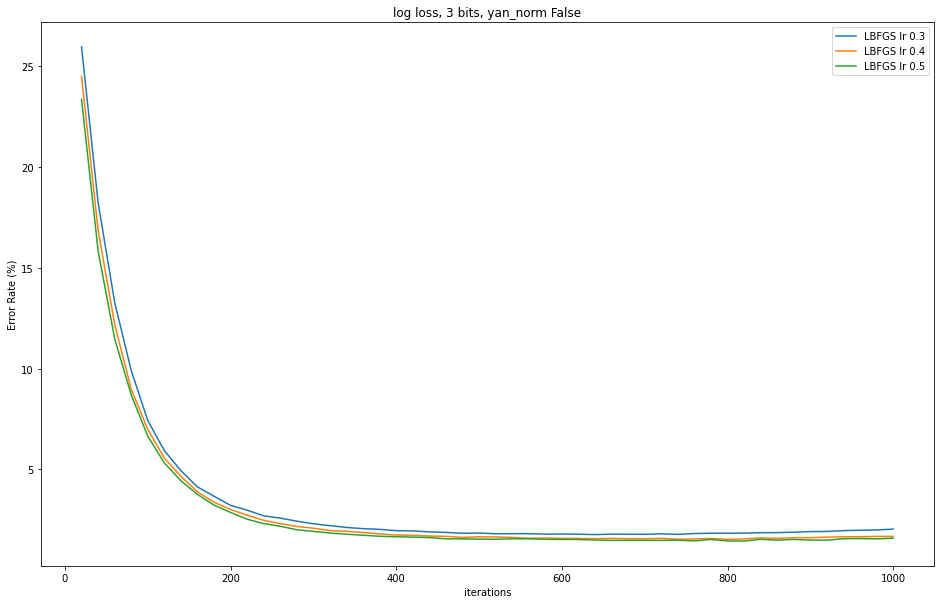

In [221]:
plt.figure(figsize=(16, 10))
# plt.plot(range(1000), np.array(bceacc) * 100, label="SGD")
for lr, acc in lbfgsacc.items():
    plt.plot(np.arange(1, steps // max_iter + 1) * max_iter, np.array(acc[:steps // max_iter]) * 100, label=f"LBFGS lr {lr}")
plt.legend()
plt.ylabel("Error Rate (%)")
plt.xlabel("iterations")
plt.title(f"{loss_mode} loss, {num_bits} bits, yan_norm {yan_norm}")
# plt.ylim(0, 0.01)
plt.show()

In [92]:
new_weights = model.state_dict()

In [96]:
for k in new_weights.keys():
    print(k, torch.norm(old_dict[k].float() - new_weights[k].float()))

layers.0.weight tensor(0., device='cuda:0')
layers.0.bias tensor(0., device='cuda:0')
layers.2.weight tensor(0., device='cuda:0')
layers.2.bias tensor(0., device='cuda:0')
layers.2.running_mean tensor(0., device='cuda:0')
layers.2.running_var tensor(0., device='cuda:0')
layers.2.num_batches_tracked tensor(0., device='cuda:0')
layers.3.weight tensor(0., device='cuda:0')
layers.3.bias tensor(0., device='cuda:0')
layers.5.weight tensor(0., device='cuda:0')
layers.5.bias tensor(0., device='cuda:0')
layers.5.running_mean tensor(0., device='cuda:0')
layers.5.running_var tensor(0., device='cuda:0')
layers.5.num_batches_tracked tensor(0., device='cuda:0')
layers.6.weight tensor(0., device='cuda:0')
layers.6.bias tensor(0., device='cuda:0')
layers.8.weight tensor(0., device='cuda:0')
layers.8.bias tensor(0., device='cuda:0')
layers.8.running_mean tensor(0., device='cuda:0')
layers.8.running_var tensor(0., device='cuda:0')
layers.8.num_batches_tracked tensor(0., device='cuda:0')
layers.9.weight 

In [32]:
accs.keys()

dict_keys(['hingelogacc', 'bceacc', 'hingeacc', 'logacc'])

In [31]:
import pickle
with open("accs.pkl", "rb") as f:
    accs = pickle.load(f)

In [245]:
image.shape

torch.Size([1, 3, 450, 612])

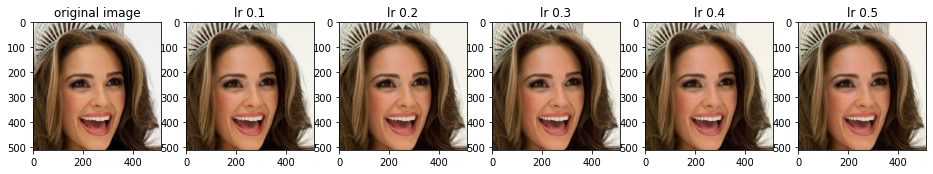

In [104]:
fig, axs = plt.subplots(1, len(lbfgsimg)+1, figsize=(16, 6))

axs[0].imshow(image.cpu().squeeze().permute(2,1,0))
axs[0].set_title("original image")
for i, alpha in enumerate([0.1, 0.2, 0.3, 0.4, 0.5]):
    axs[i+1].imshow(lbfgsimg[alpha])
    axs[i+1].set_title(f"lr {alpha}")

In [170]:
print("Number of Incorrect bits:")
print(len(torch.nonzero(output.float().view(-1) != target.view(-1))))
print("Total bits:")
print(target.numel())
print("Error rate:")
print(len(torch.nonzero(output.float().view(-1) != target.view(-1))) / target.numel())

Number of Incorrect bits:
44
Total bits:
275400
Error rate:
0.0001597676107480029


In [105]:
# lbfgs2

lbfgsacc = {}
lbfgsimg = {}

steps = 2000
eps = 0.2
adv_image = image.clone().detach()
max_iter = 20

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print("alpha:", alpha)
    accuracy = []

    for i in trange(steps // max_iter):
        adv_image.requires_grad = True
        optimizer = LBFGS([adv_image], lr=alpha, max_iter=max_iter)

        def closure():
            outputs = model(adv_image)
            loss = get_loss(output, target, loss_mode) + criterion2(adv_image, image)

            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        delta = torch.clamp(adv_image - image, min=-eps, max=eps)
        adv_image = torch.clamp(image + delta, min=0, max=1).detach()

        acc = len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel()
        print(acc)
        accuracy.append(acc)

    lbfgsacc[alpha] = accuracy
    lbfgsimg[alpha] = adv_image.cpu().squeeze().permute(2,1,0)

100